In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
import tensorflow
import glob
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pickle
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn import metrics
import seaborn as sns

## Load the Dataset

In [3]:
paths = []
labels = []
for dirname, _, filenames in os.walk('./TESS_Dataset/TESS Toronto emotional speech set data/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        label = label.lower()
        labels.append(label)

print("Dataset is loaded")

Dataset is loaded


In [4]:
paths[:5]

['./TESS_Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_thin_angry.wav',
 './TESS_Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_deep_angry.wav',
 './TESS_Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_pole_angry.wav',
 './TESS_Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_lid_angry.wav',
 './TESS_Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_match_angry.wav']

In [5]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

## Create a DataFrame 

In [6]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,./TESS_Dataset/TESS Toronto emotional speech s...,angry
1,./TESS_Dataset/TESS Toronto emotional speech s...,angry
2,./TESS_Dataset/TESS Toronto emotional speech s...,angry
3,./TESS_Dataset/TESS Toronto emotional speech s...,angry
4,./TESS_Dataset/TESS Toronto emotional speech s...,angry


In [7]:
df['label'].value_counts()

angry      400
sad        400
fear       400
disgust    400
neutral    400
happy      400
ps         400
Name: label, dtype: int64

## Exploratory Data Analysis

<AxesSubplot: xlabel='label', ylabel='count'>

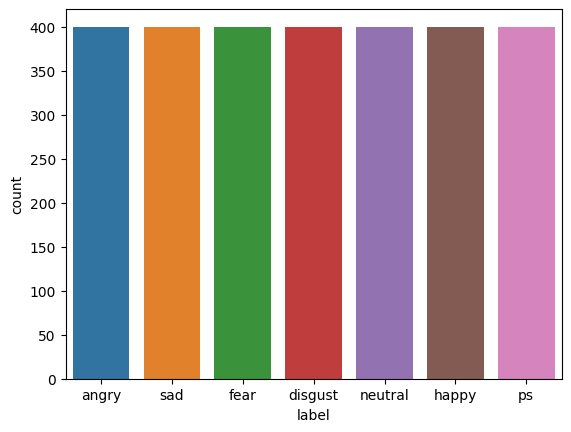

In [8]:
sns.countplot(x="label",data=df)

In [9]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
path

'./TESS_Dataset/TESS Toronto emotional speech set data/YAF_fear/YAF_white_fear.wav'

## Data Preprocessing

In [10]:
X = []
Y = []

In [11]:
def get_log_mel_spectrogram(path, n_fft, hop_length, n_mels):
    """
    Extract log mel spectrogram
        1) The length of the raw audio used is 8s long,
        2) and then get the MelSpectrogram,
        2) finally perform logarithmic operation to MelSpectrogram.
    Return:
        log_mel_spectrogram:
    """
    y, sr = librosa.load(path)

    file_length = np.size(y)
    """
     3 is the duration of each file.
    """
    if file_length != sr*3:
        y = np.concatenate((y, np.zeros(sr*3-file_length)), axis=0)

    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)

    return log_mel_spectrogram


In [12]:
def get_data(paths):
    for i in range(len(paths)):
        if i%50==0:
            print("i= ",i)
        path = paths[i]
        data = get_log_mel_spectrogram(path,n_fft=2048, hop_length=512, n_mels=128)
        X.append(data)
        Y.append(labels[i])

In [36]:
get_data(paths)

i=  0
i=  50
i=  100
i=  150
i=  200
i=  250
i=  300
i=  350
i=  400
i=  450
i=  500
i=  550
i=  600
i=  650
i=  700
i=  750
i=  800
i=  850
i=  900
i=  950
i=  1000
i=  1050
i=  1100
i=  1150
i=  1200
i=  1250
i=  1300
i=  1350
i=  1400
i=  1450
i=  1500
i=  1550
i=  1600
i=  1650
i=  1700
i=  1750
i=  1800
i=  1850
i=  1900
i=  1950
i=  2000
i=  2050
i=  2100
i=  2150
i=  2200
i=  2250
i=  2300
i=  2350
i=  2400
i=  2450
i=  2500
i=  2550
i=  2600
i=  2650
i=  2700
i=  2750


In [44]:
print(len(X),len(Y))
print(X[0].shape)

2800 2800
(128, 130)


## Visualizing the spectogram

In [49]:
def display_spectogram(X):
    randomIndexes = np.random.randint(1,2821,10)
    for i in range(10):
        fig,ax = plt.subplots()
        S_db = librosa.power_to_db(X[i],ref=np.max)
        img = librosa.display.specshow(S_db,sr=22050,fmax=11025,ax=ax)
        fig.colorbar(img,ax=ax,format='%+2.0f dB')
        ax.set(title='Logarithmic Mel-frequency spectogram')
        plt.show()

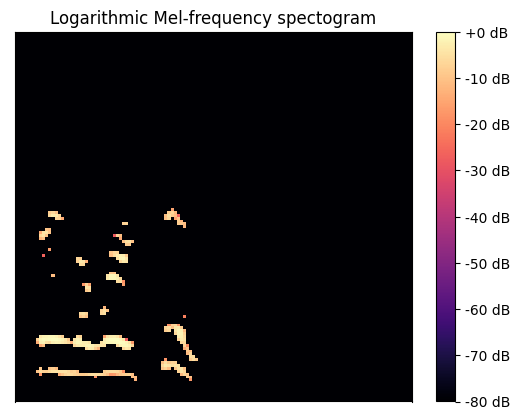

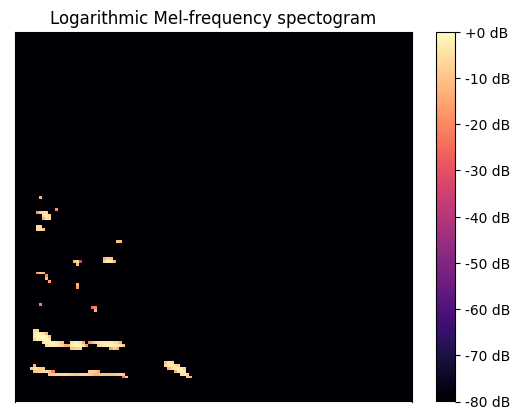

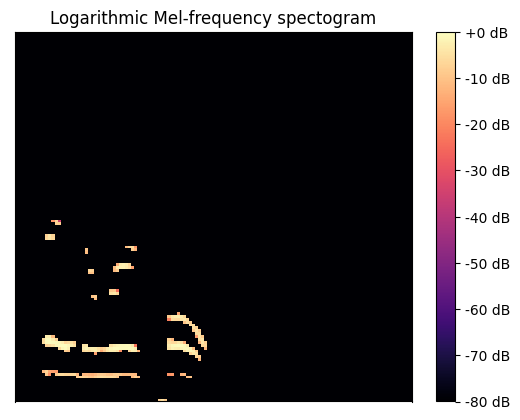

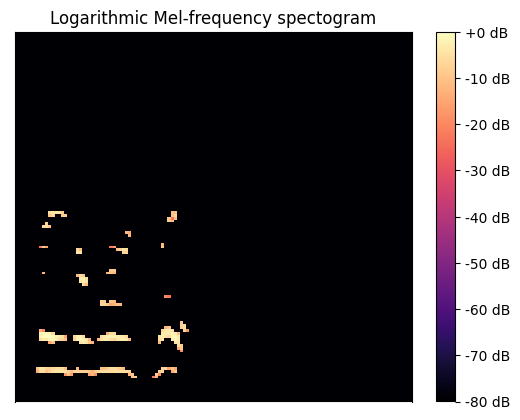

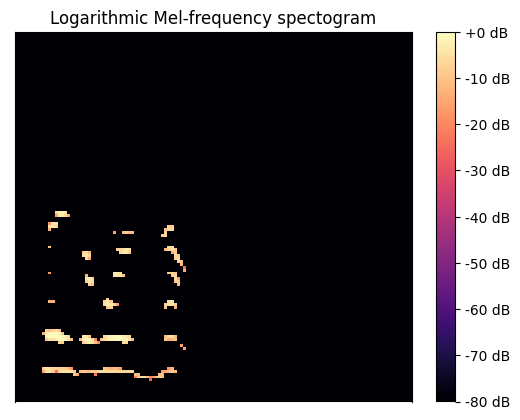

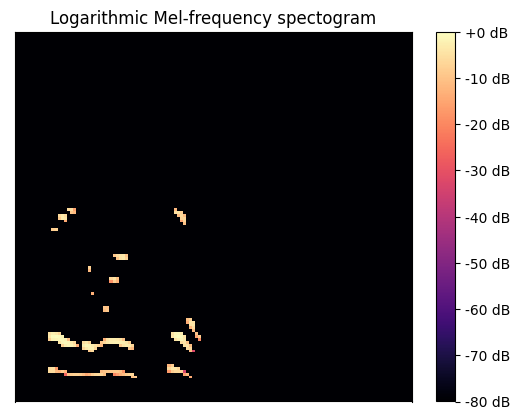

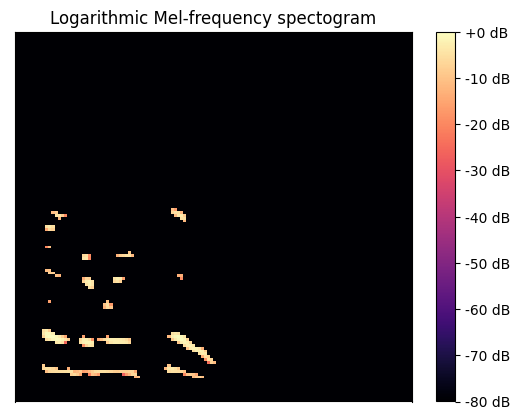

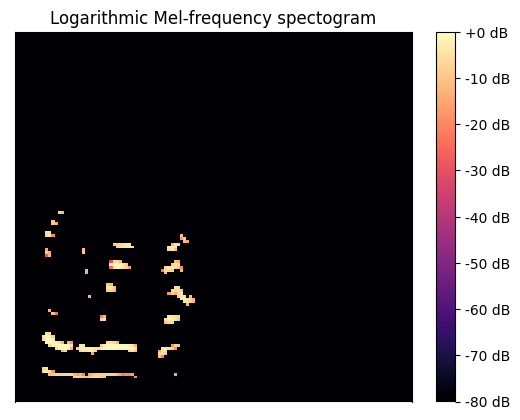

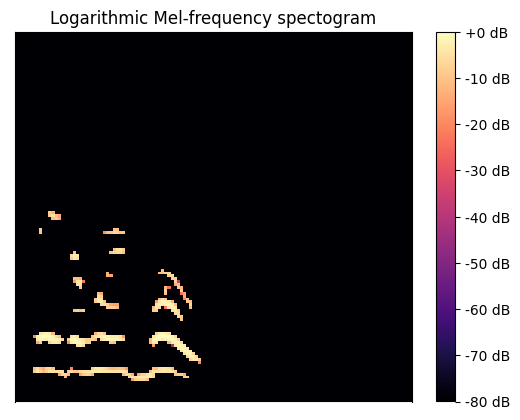

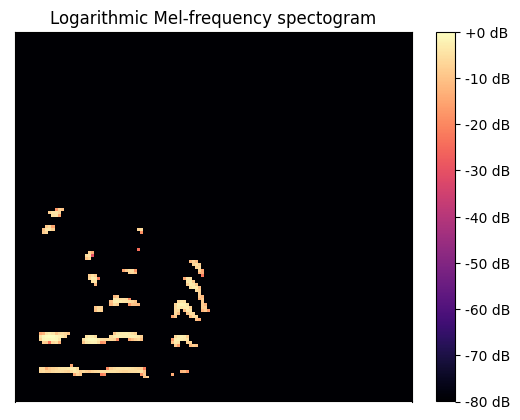

In [50]:
display_spectogram(X)

In [52]:
temp = X
temp = np.array(temp)

In [53]:
print(temp.shape)

(2800, 128, 130)


In [54]:
X = temp

In [56]:
print(type(X),X.shape)

<class 'numpy.ndarray'> (2800, 128, 130)


In [57]:
X = X.reshape(2800,128,130,1)

In [58]:
print(X.shape)

(2800, 128, 130, 1)


In [59]:
enc = OneHotEncoder()
Y = enc.fit_transform(df[['label']])
Y = Y.toarray()

In [60]:
print(Y.shape)

(2800, 7)


## Save the Data

In [61]:
np.save('mel_spectogram_X.npy', X) # save
np.save('mel_spectogram_Y.npy',Y) # save

In [3]:
#Load the Data
X = np.load('mel_spectogram_X.npy') # load
Y = np.load('mel_spectogram_Y.npy') #load

In [4]:
print(X.shape,Y.shape)

(2800, 128, 130, 1) (2800, 7)


### Split data in train,test and validation sets

In [5]:
X_Train,X_Test,Y_Train,Y_Test = train_test_split(X,Y,random_state=1,shuffle=True,test_size=0.2)

In [6]:
X_Train,X_Validation,Y_Train,Y_Validation = train_test_split(X_Train,Y_Train,random_state=2,shuffle=True,test_size=0.125)

In [7]:
print(X_Train.shape,Y_Train.shape)
print(X_Test.shape,Y_Test.shape)
print(X_Validation.shape,Y_Validation.shape)

(1960, 128, 130, 1) (1960, 7)
(560, 128, 130, 1) (560, 7)
(280, 128, 130, 1) (280, 7)


## Use CNN + LSTM 

In [9]:
model = Sequential()
model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding='same',input_shape=(128,130,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=4,strides=4))
model.add(Reshape((-1,128)))
model.add(LSTM(32))
model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 130, 64)      640       
                                                                 
 batch_normalization_2 (Batc  (None, 128, 130, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 128, 130, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 65, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 65, 64)        36928     
                                                                 
 batch_normalization_3 (Batc  (None, 64, 65, 64)      

In [12]:
adam = Adam(lr=0.0003)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [13]:
best_model = ModelCheckpoint('./best_model_spectogram_cnn_lstm.h5', monitor='val_accuracy', mode='max', save_best_only=True)
early_stop=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [12]:
hist = model.fit(X_Train,Y_Train,shuffle=True,batch_size=16,epochs=100,validation_data=(X_Validation,Y_Validation),callbacks=[best_model,early_stop])

Epoch 1/100
123/123 [==============================] - 22s 162ms/step - loss: 1.6982 - accuracy: 0.2939 - val_loss: 2.3550 - val_accuracy: 0.1893
Epoch 2/100
123/123 [==============================] - 24s 196ms/step - loss: 1.6175 - accuracy: 0.3321 - val_loss: 1.7396 - val_accuracy: 0.3214
Epoch 3/100
123/123 [==============================] - 24s 199ms/step - loss: 1.6139 - accuracy: 0.3219 - val_loss: 1.5358 - val_accuracy: 0.4000
Epoch 4/100
123/123 [==============================] - 24s 196ms/step - loss: 1.6038 - accuracy: 0.3332 - val_loss: 1.5021 - val_accuracy: 0.4393
Epoch 5/100
123/123 [==============================] - 25s 201ms/step - loss: 1.5851 - accuracy: 0.3439 - val_loss: 1.5349 - val_accuracy: 0.3964
Epoch 6/100
123/123 [==============================] - 24s 197ms/step - loss: 1.5508 - accuracy: 0.3704 - val_loss: 1.4594 - val_accuracy: 0.4464
Epoch 7/100
123/123 [==============================] - 24s 199ms/step - loss: 1.4875 - accuracy: 0.3801 - val_loss: 1.4612 -

Epoch 57/100
123/123 [==============================] - 25s 205ms/step - loss: 0.0244 - accuracy: 0.9944 - val_loss: 0.0816 - val_accuracy: 0.9786
Epoch 58/100
123/123 [==============================] - 24s 198ms/step - loss: 0.0173 - accuracy: 0.9974 - val_loss: 0.0649 - val_accuracy: 0.9857
Epoch 59/100
123/123 [==============================] - 26s 210ms/step - loss: 0.0100 - accuracy: 0.9995 - val_loss: 0.0563 - val_accuracy: 0.9821
Epoch 60/100
123/123 [==============================] - 26s 209ms/step - loss: 0.0516 - accuracy: 0.9878 - val_loss: 0.8736 - val_accuracy: 0.7786
Epoch 61/100
123/123 [==============================] - 25s 202ms/step - loss: 0.1207 - accuracy: 0.9714 - val_loss: 0.1082 - val_accuracy: 0.9714
Epoch 62/100
123/123 [==============================] - 25s 202ms/step - loss: 0.0333 - accuracy: 0.9913 - val_loss: 0.0659 - val_accuracy: 0.9786
Epoch 63/100
123/123 [==============================] - 25s 202ms/step - loss: 0.2107 - accuracy: 0.9347 - val_loss: 0

In [13]:
!touch saved_hist_spectogram_cnn_lstm.pkl

In [14]:
with open('saved_hist_spectogram_cnn_lstm.pkl','wb') as f:
    pickle.dump(hist.history,f)

In [14]:
with open('saved_hist_spectogram_cnn_lstm.pkl','rb') as f:
    history = pickle.load(f)

In [15]:
font = {'family' : '',
        'weight' : 'bold',
        'size'   : 8.5}

plt.rc('font', **font)

## Plot the results

In [28]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

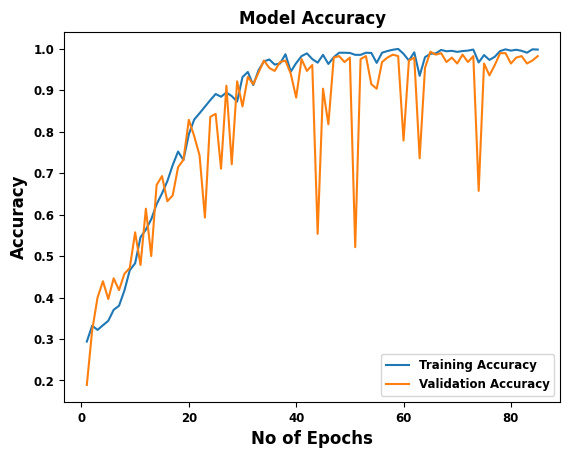

In [29]:
epochs = np.arange(1,86,1)
plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Accuracy",fontsize=12,fontweight='bold')
plt.title("Model Accuracy",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('cnn_lstm_model_accuracy')
plt.show()

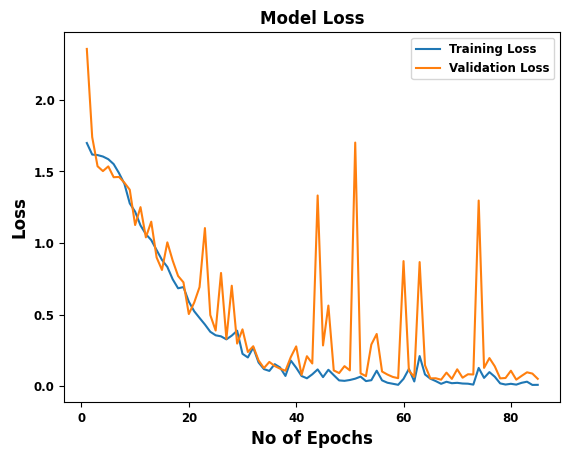

In [30]:
epochs = np.arange(1,86,1)
plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Loss",fontsize=12,fontweight='bold')
plt.title("Model Loss",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('cnn_lstm_model_loss')
plt.show()

In [16]:
model.load_weights('best_model_spectogram_cnn_lstm.h5')

In [17]:
model.evaluate(X_Test,Y_Test)

18/18 [==============================] - 3s 89ms/step - loss: 0.0671 - accuracy: 0.9821


[0.06705828756093979, 0.9821428656578064]

### Confusion Matrix

In [18]:
predict_x = model.predict(X_Test)
Y_Pred = np.argmax(predict_x,axis=1)

18/18 [==============================] - 2s 87ms/step


In [19]:
Y_actual = np.argmax(Y_Test,axis=1)
cnf_matrix = confusion_matrix(Y_actual,Y_Pred)
print(cnf_matrix)

[[79  0  0  1  0  0  0]
 [ 2 84  0  0  0  0  1]
 [ 0  0 78  0  0  0  0]
 [ 1  0  1 78  0  0  0]
 [ 0  0  0  0 86  0  0]
 [ 0  1  0  1  0 73  0]
 [ 0  0  2  0  0  0 72]]


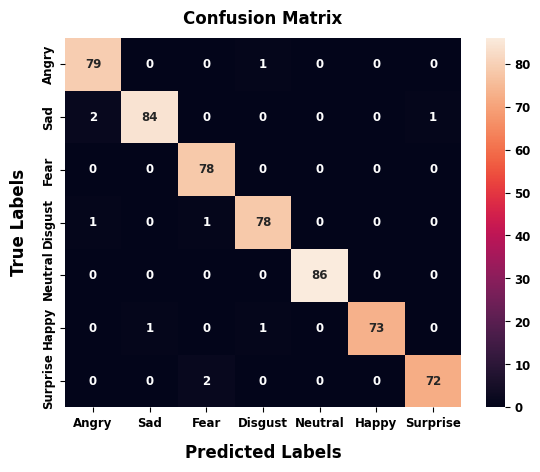

In [35]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted Labels',fontsize=12,fontweight='bold',labelpad=10);
ax.set_ylabel('True Labels',fontsize=12,fontweight='bold',labelpad=10); 
ax.set_title('Confusion Matrix',fontsize=12,fontweight='bold',pad=10); 
ax.xaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']); ax.yaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']);
plt.savefig('cnn_lstm_confusion_matrix')

### Classification Report

In [20]:
print(classification_report(Y_actual, Y_Pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98        80
           1       0.99      0.97      0.98        87
           2       0.96      1.00      0.98        78
           3       0.97      0.97      0.97        80
           4       1.00      1.00      1.00        86
           5       1.00      0.97      0.99        75
           6       0.99      0.97      0.98        74

    accuracy                           0.98       560
   macro avg       0.98      0.98      0.98       560
weighted avg       0.98      0.98      0.98       560



### Sensitivity and Specificity

In [21]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

In [22]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [23]:
TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
ACC = (TP+TN)/(TP+FP+FN+TN)
FPR = FP/(FP+TN)

In [24]:
print("Sensitivity = ",TPR)
print("Specificity = ",TNR)
print("accuracy for each class = ",ACC)

Sensitivity =  [0.9875     0.96551724 1.         0.975      1.         0.97333333
 0.97297297]
Specificity =  [0.99375    0.99788584 0.99377593 0.99583333 1.         1.
 0.99794239]
accuracy for each class =  [0.99285714 0.99285714 0.99464286 0.99285714 1.         0.99642857
 0.99464286]


### ROC Curve 

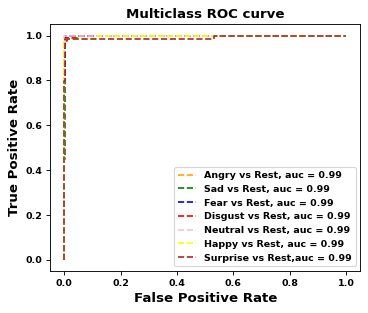

In [25]:
### ROC Curve
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
auc = {}
y_prob_pred_cnb = predict_x

n_class = 7
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(Y_actual, y_prob_pred_cnb[:,i], pos_label=i)
    auc[i] = metrics.roc_auc_score(Y_actual,y_prob_pred_cnb,multi_class='ovr',average='weighted')
plt.figure(figsize=(5, 4),dpi=80)   
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Angry vs Rest, auc = '+str(auc[0])[:4])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Sad vs Rest, auc = '+str(auc[1])[:4])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Fear vs Rest, auc = '+str(auc[2])[:4])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Disgust vs Rest, auc = '+str(auc[3])[:4])
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Neutral vs Rest, auc = '+str(auc[4])[:4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='yellow', label='Happy vs Rest, auc = '+str(auc[5])[:4])
plt.plot(fpr[6], tpr[6], linestyle='--',color='brown', label='Surprise vs Rest,auc = '+str(auc[6])[:4])
plt.title('Multiclass ROC curve',fontsize=12,fontweight='bold')
plt.xlabel('False Positive Rate',fontsize=12,fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=12,fontweight='bold')
plt.legend(loc='best')
plt.savefig('cnn_lstm_Multiclass_ROC',dpi=80);    